## Example run to show both what happens to covariates which don't pass k_top and ones which do 

In [1]:
#libs
from os import listdir
from os.path import isfile, join
import os
import pandas as pd
import numpy as np
import scipy as scipy
import statistics
import math
import re


from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import silhouette_score
import scanpy as sc
from itertools import chain
import numpy as np
from tqdm import tqdm
import time
from random import sample
from random import seed
import random
from scipy import stats
from scipy.stats import ks_2samp

# Set variables

In [2]:
data = "/Users/emilyjones/Desktop/HCA/project/script templates/mouse/mouse_exp1_exp2_concat.h5ad"
covariate = 'batch_id'
run_name = "pb_mouse_raw"

# How many montecarlo sampling iterations to carry out
k_iter = 100

# How many results that pass QC do you want to keep for each unique cateogry? (this increases number of cells output but there can also be overlap in sampling)
k_top = 20

# How many percent of each unique category do you want to sample for each iteration? 
n_percent = 50

# How many top DEGs to use
de_num = 30

# Possible options to include to control: strictness of sample passing criteria (0.97 default) and number of EPOCH's to perform before starting next celltype


# Provide custom long format DEGS?
Use_cutom_degs = False
#DEG_dir = ''
#cov_cat = 'cluster'
#Ranking_cat = 'p_val_adj'
#Gene_cat = 'gene'
#Rank_by_ascending_or_descending = 'ascending' # or 'descending'


# Let's make a cell-identify aware subsampling alg which makes sure that cells returned have the same top-DEG module score distribution as the entire cluster

# Subsample by fraction of the current cell populations by a given covariate k number of times

In [3]:
def long_format_DEGS():
    sc.tl.rank_genes_groups(adata, covariate, method='wilcoxon',n_genes=50)
    sc.pl.rank_genes_groups(adata, n_genes=50, sharey=False)

    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    DE = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(50)
    degs = DE[:]
    if 'concat' in locals() or 'concat' in globals():
        del(concat)
    n = degs.loc[:, degs.columns.str.endswith("_n")]
    n = pd.melt(n)
    p = degs.loc[:, degs.columns.str.endswith("_p")]
    p = pd.melt(p)
    l = degs.loc[:, degs.columns.str.endswith("_l")]
    l = pd.melt(l)
    n = n.replace(regex=r'_n', value='')
    n = n.rename(columns={"variable": "cluster", "value": "gene"})
    p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "p_val"})
    l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})
    concat = pd.concat([n,p,l],axis=1)
    #remove mito genes from data
    concat = concat[~concat["gene"].str.startswith("MT-")]
    concat = concat[~concat["gene"].str.startswith("RP11-")]
    concat.to_csv("./" + run_name + '_DEGS.csv')
    return concat

def monte_carlo_sc_samp():
    if Use_cutom_degs==False:
        concat = long_format_DEGS()
        index_out = pd.DataFrame(columns=['ks_results','sub_id','nest','cov','cov_sub_id']) # new index_out assignment 
        adata.obs[covariate] = adata.obs[covariate].astype(str)
        concat['cluster'] = concat['cluster'].astype(str)
        for x in adata.obs[covariate].unique():
            print('starting iterations for covariate: ' + str(x))
            temp_mat = adata[adata.obs[covariate].isin([x])]
            del temp_mat.raw
            simulations = k_iter #how many tests to do
            iterations = k_top #how many success to choose
            sampling = n_percent
            #Gaussian distribution of values between mean and std of all segmented cells in FOV
            # By only taking into account mean and std of segmented cells, we are able to make a fairer estimation for comparison else, an empty area might be studied instead
            # generate random Gaussian values
            #Create a modulescore for top 20genes in temp_mat
            gene_list = list(concat['gene'][concat['cluster'].isin([x])].head(de_num))
            sc.tl.score_genes(temp_mat, gene_list, ctrl_size=50, gene_pool=None, n_bins=25, score_name='loop_score', random_state=0, copy=False, use_raw=None)
            # Count number of passed samples, if passed, reset counter and +1 to passed_counter till passed_counter = k_iter
            # create data structure to hold iteration indexes and results
            counter = int(0)
            passed = False
            while passed == False:
                ks_results = []
                indexes = []
                k = list(range(0,k_iter,1))
                for n in tqdm(k):
                    time.sleep(0.01)
                    ##Subsample by frac
                    grouped = temp_mat.obs.groupby(covariate)
                    df = grouped.apply(lambda x: x.sample(frac=(n_percent/100)))
                    df = df.droplevel(covariate)
                    keep = df.index
                    # KS test for equivilent distribution
                    mod_sc = temp_mat.obs['loop_score'][temp_mat.obs.index.isin(keep)]
                    ks_test = ks_2samp(temp_mat.obs['loop_score'],mod_sc)
                    ks_results.append(ks_test[1])
                    indexes.append(keep)
                qc_ks = [i for i in ks_results if i >= 0.97]
                if len(qc_ks)>=k_top:                                      # 2 if statements now turned into 1 in order to fix bug of adding samples from every epoch run to index_out 
                    passed = True
                    print("Looped through iters in EPOCH: " + str(counter) + " and passed with numer of samples passed = " + str(len(qc_ks)))    # not accurate to look at due to cell overlap
                elif counter < int(5):
                    print("Looped through iters in EPOCH: " + str(counter))
                    print("EPOCH killed as unable to obtain suffucuent results, try increasing percent or K param or lowering N")     
                    counter = counter + int(1)
                    continue
                else:
                    print("Looped through iters in EPOCH: " + str(counter))                                            # to filter just recovered samples if don't meet k_top ready for pseudobulking
                    print("EPOCH killed as unable to obtain suffucuent results. Running no more EPOCH's for " + str(x))    
                    print("Recovered n=" + str(len(qc_ks)) + " passed samples for covariate: " + str(x) )
                    print("Procedding with recovered n=" + str(len(qc_ks)))
                    result_df = pd.DataFrame(ks_results,columns= ['ks_results'])
                    result_df = result_df[result_df['ks_results'] >= 0.97]
                    result_df['sub_id'] = result_df.index
                    result_df['nest'] = ''
                    for y in result_df['sub_id'].unique():
                        temp_index = list(indexes[y])
                        result_df.at[y, 'nest'] =  temp_index
                    result_df['cov'] = x
                    result_df['cov_sub_id'] = result_df['cov'].astype(str) + '_' + result_df['sub_id'].astype(str)
                    result_df = result_df.sort_values(by=['ks_results'], ascending=False)
                    k_kept = result_df.head(k_top)
                    index_out = pd.concat([index_out,k_kept])
                    break
            
                result_df = pd.DataFrame(ks_results,columns= ['ks_results'])
                result_df['sub_id'] = result_df.index
                result_df['nest'] = ''
                for y in result_df['sub_id'].unique():
                    temp_index = list(indexes[y])
                    result_df.at[y, 'nest'] =  temp_index
                result_df['cov'] = x
                result_df['cov_sub_id'] = result_df['cov'].astype(str) + '_' + result_df['sub_id'].astype(str)
                result_df = result_df.sort_values(by=['ks_results'], ascending=False)
                k_kept = result_df.head(k_top)
                index_out = pd.concat([index_out,k_kept])
    else:
        print('Custom gene list option detected, proceeding to read .csv')
        index_out = pd.DataFrame(columns=['ks_results','sub_id','nest','cov','cov_sub_id']) # new index_out assignment
        adata.obs[covariate] = adata.obs[covariate].astype(str)
        concat = pd.read_csv(DEG_dir)
        #Rank by ranking metric
        if Rank_by_ascending_or_descending == 'ascending':
            concat = concat.sort_values([cov_cat,Ranking_cat],ascending=True).groupby(cov_cat).head(de_num)
        else:
            concat = concat.sort_values([cov_cat,Ranking_cat],ascending=False).groupby(cov_cat).head(de_num)
        concat[cov_cat] = concat[cov_cat].astype(str)

        for x in adata.obs[covariate].unique():
            print('starting iterations for covariate: ' + str(x))
            temp_mat = adata[adata.obs[covariate].isin([x])]
            del temp_mat.raw
            gene_list = list(concat[Gene_cat][concat[cov_cat].isin([x])])
            sc.tl.score_genes(temp_mat, gene_list, ctrl_size=50, gene_pool=None, n_bins=25, score_name='loop_score', random_state=0, copy=False, use_raw=None)
            simulations = k_iter #how many tests to do
            iterations = k_top #how many success to choose
            sampling = n_percent

            #Gaussian distribution of values between mean and std of all segmented cells in FOV
            # By only taking into account mean and std of segmented cells, we are able to make a fairer estimation for comparison else, an empty area might be studied instead
            # generate random Gaussian values

            #Create a modulescore for top 20genes in temp_mat
            gene_list = list(concat['gene'][concat['cluster'].isin([x])].head(de_num))
            sc.tl.score_genes(temp_mat, gene_list, ctrl_size=50, gene_pool=None, n_bins=25, score_name='loop_score', random_state=0, copy=False, use_raw=None)

            # Count number of passed samples, if passed, reset counter and +1 to passed_counter till passed_counter = k_iter
            # create data structure to hold iteration indexes and results
            counter = int(0)
            passed = False

            while passed == False:
                ks_results = []
                indexes = []
                k = list(range(0,k_iter,1))
                for n in tqdm(k):
                    time.sleep(0.01)
                    ##Subsample by frac
                    grouped = temp_mat.obs.groupby(covariate)
                    df = grouped.apply(lambda x: x.sample(frac=(n_percent/100)))
                    df = df.droplevel(covariate)
                    keep = df.index

                    # KS test for equivilent distribution
                    mod_sc = temp_mat.obs['loop_score'][temp_mat.obs.index.isin(keep)]
                    ks_test = ks_2samp(temp_mat.obs['loop_score'],mod_sc)

                    ks_results.append(ks_test[1])
                    indexes.append(keep)

                qc_ks = [i for i in ks_results if i >= 0.97]
                if len(qc_ks)>=k_top:                        # 2 if statements now turned into 1 in order to fix bug of adding samples from every epoch run to index_out 
                    passed = True
                    print("Looped through iters in EPOCH: " + str(counter) + " and passed with numer of samples passed = " + str(len(qc_ks)))    # not accurate to look at due to cell overlap
                elif counter < int(5):
                    print("Looped through iters in EPOCH: " + str(counter))
                    print("EPOCH killed as unable to obtain suffucuent results, try increasing percent or K param or lowering N")     
                    counter = counter + int(1)
                    continue
                else:
                    print("Looped through iters in EPOCH: " + str(counter))                                               # to filter just recovered samples if don't meet k_top ready for pseudobulking
                    print("EPOCH killed as unable to obtain suffucuent results. Running no more EPOCH's for " + str(x))    
                    print("Recovered n=" + str(len(qc_ks)) + " passed samples for covariate: " + str(x) )
                    print("Procedding with recovered n=" + str(len(qc_ks)))
                    result_df = pd.DataFrame(ks_results,columns= ['ks_results'])
                    result_df = result_df[result_df['ks_results'] >= 0.97]
                    result_df['sub_id'] = result_df.index
                    result_df['nest'] = ''
                    for y in result_df['sub_id'].unique():
                        temp_index = list(indexes[y])
                        result_df.at[y, 'nest'] =  temp_index
                    result_df['cov'] = x
                    result_df['cov_sub_id'] = result_df['cov'].astype(str) + '_' + result_df['sub_id'].astype(str)
                    result_df = result_df.sort_values(by=['ks_results'], ascending=False)
                    k_kept = result_df.head(k_top)
                    index_out = pd.concat([index_out,k_kept])
                    break

            result_df = pd.DataFrame(ks_results,columns= ['ks_results'])     #rewritten section with issac 17082021
            result_df['sub_id'] = result_df.index
            result_df['nest'] = ''
            for y in result_df['sub_id'].unique():
                temp_index = list(indexes[y])
                result_df.at[y, 'nest'] =  temp_index
            result_df['cov'] = x
            result_df['cov_sub_id'] = result_df['cov'].astype(str) + '_' + result_df['sub_id'].astype(str)
            result_df = result_df.sort_values(by=['ks_results'], ascending=False)
            k_kept = result_df.head(k_top)
            index_out = pd.concat([index_out,k_kept])
            index_out.to_csv("./" + run_name + '_index_out.csv')
    return index_out

def pseudo_bulk(adata, groupby, use_rep='X', highly_variable=False, FUN=np.mean):
    if adata.obs[groupby].dtype.name == 'category':
        group_attr = adata.obs[groupby].values
        groups = adata.obs[groupby].cat.categories.values
    else:
        group_attr = adata.obs[groupby].astype(str).values
        groups = np.unique(group_attr)
    n_level = len(groups)
    if highly_variable:
        if isinstance(highly_variable, (list, tuple)):
            k_hv = adata.var_names.isin(highly_variable)
        else:
            k_hv = adata.var['highly_variable'].values
    if use_rep == 'X':
        x = adata.X
        features = adata.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep in adata.layers.keys():
        x = adata.layers[use_rep]
        features = adata.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep in adata.obsm.keys():
        x = adata.obsm[use_rep]
        features = np.arange(x.shape[1])
    elif (isinstance(use_rep, np.ndarray) and
            use_rep.shape[0] == adata.shape[0]):
        x = use_rep
        features = np.arange(x.shape[1])
    else:
        raise KeyError(f'{use_rep} invalid.')
    summarised = np.zeros((n_level, x.shape[1]))
    for i, grp in enumerate(groups):
        k_grp = group_attr == grp
        summarised[i] = FUN(x[k_grp, :], axis=0)
    return pd.DataFrame(summarised.T, columns=groups, index=features)

def create_psb():
    adata.obs[covariate] = adata.obs[covariate].astype(str) # removed previous assignment of index['cov_sub_id'] as now added earlier in script
    if 'psd_blk_mat_concat' in locals() or 'psd_blk_mat_concat' in globals():
        psd_blk_mat_concat = ''
        del(psd_blk_mat_concat)
    if (len(index_out) == 0):
        raise TypeError('No samples present for pseudobulking! Check parameters and if any samples passed') # Final check to make sure index_out has values in order to pseudo bulk 
    for cov_lp in index_out['cov'].unique():
        print(cov_lp)
        index_temp = index_out[index_out['cov'].isin([cov_lp])]
        for sub_id in index_temp['cov_sub_id'].unique():
            index_psd = list(chain.from_iterable(index_temp['nest'][index_temp['cov_sub_id'].isin([sub_id])]))
            psd_blk = adata[adata.obs.index.isin(index_psd)]
            psd_blk.obs['cov_sub_id'] = sub_id
            psd_blk_mat = pseudo_bulk(psd_blk, 'cov_sub_id', use_rep='X', highly_variable=False, FUN=np.mean)
            if 'psd_blk_mat_concat' in locals():
                psd_blk_mat_concat = pd.concat([psd_blk_mat_concat, psd_blk_mat], axis = 1)
            else:
                psd_blk_mat_concat = psd_blk_mat
    mapper = dict(zip((list(index_out['cov_sub_id'])),(list(index_out['cov']))))
    adata_sub = sc.AnnData(psd_blk_mat_concat.T)
    adata_sub.obs[covariate] = adata_sub.obs.index
    adata_sub.obs[covariate] = adata_sub.obs[covariate].map(mapper)
    adata_sub.obs['pseudo_id'] = adata_sub.obs.index
    return adata_sub

/Applications/anaconda3/envs/python_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Applications/anaconda3/envs/python_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/Applications/anaconda3/envs/python_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Applications/anaconda3/envs/python_env/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:312: UserWarning: Attempting to set identical bottom == top == 3.0237157344818115 results in singular transformations; automatically expanding.
  ax.set_ylim(ymin, ymax)
/Applications/anaconda3/envs/python_env/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:3

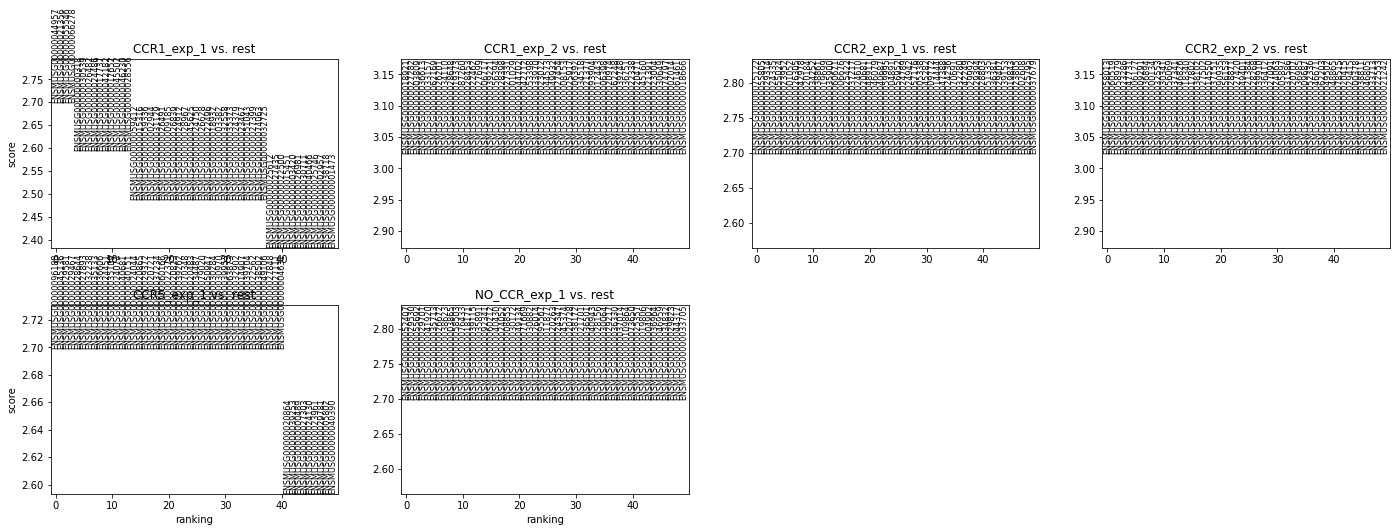

starting iterations for covariate: CCR1_exp_2


100%|██████████| 100/100 [00:01<00:00, 72.54it/s]


Looped through iters in EPOCH: 0 and passed with numer of samples passed = 60
starting iterations for covariate: CCR2_exp_2


100%|██████████| 100/100 [00:01<00:00, 70.24it/s]


Looped through iters in EPOCH: 0 and passed with numer of samples passed = 72
starting iterations for covariate: CCR1_exp_1


100%|██████████| 100/100 [00:01<00:00, 71.49it/s]


Looped through iters in EPOCH: 0 and passed with numer of samples passed = 100
starting iterations for covariate: CCR2_exp_1


100%|██████████| 100/100 [00:01<00:00, 68.61it/s]


Looped through iters in EPOCH: 0 and passed with numer of samples passed = 100
starting iterations for covariate: CCR5_exp_1


100%|██████████| 100/100 [00:01<00:00, 68.50it/s]


Looped through iters in EPOCH: 0 and passed with numer of samples passed = 100
starting iterations for covariate: NO_CCR_exp_1


100%|██████████| 100/100 [00:01<00:00, 65.78it/s]
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Looped through iters in EPOCH: 0 and passed with numer of samples passed = 100
CCR1_exp_2


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


CCR2_exp_2


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


CCR1_exp_1


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


CCR2_exp_1


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


CCR5_exp_1


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


NO_CCR_exp_1


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
/Applications/anaconda3/envs/python_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=T

In [4]:
adata = sc.read(data)
# Removed cycling from this example as only 2 cells to begin with 
#adata = adata[~adata.obs['AGM_new_anno_12082021'].isin(['cycling_HEC'])]
index_out = monte_carlo_sc_samp()
adata_sub = create_psb()
adata_sub.obs['batch_filler'] = 'filler' # to add a column to batch correct on
adata_sub.obs.reset_index(drop=True, inplace=True) # to tidy up index

adata_sub.var = adata.var #to keep .var information

adata_sub.write("./" + run_name + '_pseudobulks.h5ad')

In [5]:
adata_sub.obs

,batch_id,pseudo_id,batch_filler
0,CCR1_exp_2,CCR1_exp_2_0,filler
1,CCR1_exp_2,CCR1_exp_2_57,filler
2,CCR1_exp_2,CCR1_exp_2_69,filler
3,CCR1_exp_2,CCR1_exp_2_65,filler
4,CCR1_exp_2,CCR1_exp_2_64,filler
...,...,...,...
115,NO_CCR_exp_1,NO_CCR_exp_1_60,filler
116,NO_CCR_exp_1,NO_CCR_exp_1_59,filler
117,NO_CCR_exp_1,NO_CCR_exp_1_58,filler
118,NO_CCR_exp_1,NO_CCR_exp_1_57,filler


In [6]:
adata.obs

,experiment_id,celltype,id,batch_id,lr_batch,batch
CCR1_R1_exp_2,exp_2,mono,CCR1_R1_mono,CCR1_exp_2,CCR1_exp_2,0
CCR1_R2_exp_2,exp_2,mono,CCR1_R2_mono,CCR1_exp_2,CCR1_exp_2,0
CCR1_R3_exp_2,exp_2,mono,CCR1_R3_mono,CCR1_exp_2,CCR1_exp_2,0
CCR1_R4_exp_2,exp_2,mono,CCR1_R4_mono,CCR1_exp_2,CCR1_exp_2,0
CCR2_R1_exp_2,exp_2,mono,CCR2_R1_mono,CCR2_exp_2,CCR2_exp_2,0
CCR2_R2_exp_2,exp_2,mono,CCR2_R2_mono,CCR2_exp_2,CCR2_exp_2,0
CCR2_R3_exp_2,exp_2,mono,CCR2_R3_mono,CCR2_exp_2,CCR2_exp_2,0
CCR2_R4_exp_2,exp_2,mono,CCR2_R4_mono,CCR2_exp_2,CCR2_exp_2,0
CCR1_R1_exp_1,exp_1,macropahge,CCR1_R1_macropahge,CCR1_exp_1,CCR1_exp_1,1
CCR1_R2_exp_1,exp_1,macropahge,CCR1_R2_macropahge,CCR1_exp_1,CCR1_exp_1,1


In [7]:
adata = sc.read("/Users/emilyjones/Desktop/HCA/project/script templates/mouse/mouse_exp1_exp2_concat.h5ad")
adata

AnnData object with n_obs × n_vars = 20 × 10957
    obs: 'experiment_id', 'celltype', 'id', 'batch_id', 'lr_batch', 'batch'
    var: 'symbol', 'biotype', 'chromosome', 'start', 'stop', 'HGNC_orth', 'mouse_ens_id', 'CCR1_mean-0', 'CCR2_mean-0', 'CCR1_median-0', 'CCR2_median-0', 'CCR1_stdev-0', 'CCR2_stdev-0', 'CCR1_mean-1', 'CCR2_mean-1', 'CCR1_median-1', 'CCR2_median-1', 'CCR1_stdev-1', 'CCR2_stdev-1', 'CCR5_mean-1', 'NO_CCR_mean-1', 'CCR5_median-1', 'NO_CCR_median-1', 'CCR5_stdev-1', 'NO_CCR_stdev-1'

In [8]:
pd.DataFrame(adata.X).iloc[:,0]

0     202.509995
1     284.119995
2     234.860001
3     270.089996
4     271.549988
5     310.299988
6     270.239990
7     260.000000
8     519.400024
9     485.799988
10    625.710022
11    246.529999
12    360.239990
13    425.000000
14    476.700012
15    494.980011
16    475.709991
17    659.549988
18    557.049988
19    811.070007
Name: 0, dtype: float32

In [9]:
adata_sub.var

,symbol,biotype,chromosome,start,stop,HGNC_orth,mouse_ens_id,CCR1_mean-0,CCR2_mean-0,CCR1_median-0,...,CCR1_median-1,CCR2_median-1,CCR1_stdev-1,CCR2_stdev-1,CCR5_mean-1,NO_CCR_mean-1,CCR5_median-1,NO_CCR_median-1,CCR5_stdev-1,NO_CCR_stdev-1
index,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000068114,CCDC134,GENE,15,82012123,82026404,CCDC134,ENSMUSG00000068114,247.8950,278.0225,252.475,...,519.40,360.24,59.633682,73.767926,482.463333,675.890000,476.70,659.55,8.859843,104.344899
ENSMUSG00000052407,CCDC171,GENE,4,83443782,83782907,CCDC171,ENSMUSG00000052407,117.9425,113.9175,113.850,...,365.35,281.64,26.114375,39.163946,288.316667,502.020000,273.83,522.29,20.848905,54.433898
ENSMUSG00000000693,LOXL3,GENE,6,83011154,83029543,LOXL3,ENSMUSG00000000693,55.4400,46.4175,55.175,...,120.06,88.64,5.329630,2.450483,152.710000,141.846667,175.34,157.81,34.957421,24.654615
ENSMUSG00000029250,POLR2B,GENE,5,77457994,77497171,POLR2B,ENSMUSG00000029250,3406.4325,3763.7625,3403.925,...,429.61,666.99,59.469215,98.477177,634.310000,371.440000,647.74,385.03,76.213787,20.411420
ENSMUSG00000053769,LYSMD1,GENE,3,95041399,95046829,LYSMD1,ENSMUSG00000053769,75.2450,74.3675,77.535,...,17.69,36.02,10.330134,11.811099,11.053333,26.666667,12.15,24.43,2.433466,4.267945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000039055,EME1,GENE,11,94535822,94544790,EME1,ENSMUSG00000039055,656.5600,321.6900,641.535,...,34.35,24.02,10.361374,7.542312,36.763333,36.916667,16.07,36.41,29.392164,10.408334
ENSMUSG00000006599,GTF2H1,GENE,7,46445527,46473224,GTF2H1,ENSMUSG00000006599,1545.5150,1631.7075,1583.810,...,718.60,561.84,32.759159,49.130367,670.063333,626.480000,612.23,643.26,105.027080,53.904461
ENSMUSG00000061751,KALRN,GENE,16,33789443,34393902,KALRN,ENSMUSG00000061751,13.0100,11.3675,12.905,...,33.31,25.37,10.238595,13.233547,97.473333,89.926667,58.33,89.57,84.217309,23.340917


In [10]:
adata_sub.var = adata.var

In [13]:
adata_sub.obs

,batch_id,pseudo_id,batch_filler
0,CCR1_exp_2,CCR1_exp_2_0,filler
1,CCR1_exp_2,CCR1_exp_2_57,filler
2,CCR1_exp_2,CCR1_exp_2_69,filler
3,CCR1_exp_2,CCR1_exp_2_65,filler
4,CCR1_exp_2,CCR1_exp_2_64,filler
...,...,...,...
115,NO_CCR_exp_1,NO_CCR_exp_1_60,filler
116,NO_CCR_exp_1,NO_CCR_exp_1_59,filler
117,NO_CCR_exp_1,NO_CCR_exp_1_58,filler
118,NO_CCR_exp_1,NO_CCR_exp_1_57,filler


In [12]:
adata_sub.X

array([[ 259.49    ,  108.995   ,   55.175003, ...,   12.905001,
        1595.895   , 3562.625   ],
       [ 236.29999 ,  126.89    ,   55.704998, ...,   13.115   ,
        1455.22    , 3506.9648  ],
       [ 259.49    ,  108.995   ,   55.175003, ...,   12.905001,
        1595.895   , 3562.625   ],
       ...,
       [ 735.31    ,  539.245   ,  133.865   , ...,   75.545   ,
         624.135   , 1459.03    ],
       [ 684.06    ,  491.885   ,  159.26001 , ...,   90.105   ,
         646.445   , 1418.505   ],
       [ 735.31    ,  539.245   ,  133.865   , ...,   75.545   ,
         624.135   , 1459.03    ]], dtype=float32)